# Check Loglikelihood with Lapse Rate Bays09

2/3

After having checked correlation between LL and EM fits, it seemed that the sigma_output was not that great. Namely, LL required non-zero sigma_output, even though it's negatively correlated with good EM Kappa fits.

Perhaps that was due to a lack of support for outliers, so now we allow that with a non-zero lapse rate. This is quite drastic currently, might need to switch to log(lapse_rate) samples to make sure it's close to 0.

Performed by *generator_LLcheck_random_fitexperimentallt_sigmaxMratiosigmaoutput_121015.py*


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
from IPython.utils import io
import scipy.stats.mstats as mstats 


from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa


# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
# import submitpbs
import load_experimental_data

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo

In [3]:
from plotly import offline as py
from plotly import graph_objs as go
py.init_notebook_mode(connected=True)


In [4]:
from IPython.html import widgets # Widget definitions
from IPython.display import display # Used to display widgets in the notebook
from IPython.html.widgets import interact
from plotly.widgets import GraphWidget 

/nfs/nhome/live/lmatthey/Applications/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning:

The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.

/nfs/nhome/live/lmatthey/Applications/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning:

IPython.utils.traitlets has moved to a top-level traitlets package.



<IPython.core.display.Javascript object>

In [5]:
%run reloader_LLlapse_random_fitexperimentallt_sigmaxMratiolapserate_131015.py

Reloader data generated from  generator_LLlapse_random_fitexperimentallt_sigmaxMratiolapserate_131015.py
Running  /nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/reloader_LLlapse_random_fitexperimentallt_sigmaxMratiolapserate_131015.py
Arguments: []

        Reload outputs run with the automatic parameter generator for PBS

        Should handle random sampling of the parameter space.
    
Reloader data generated from  generator_LLlapse_random_fitexperimentallt_sigmaxMratiolapserate_131015.py
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-007da217-c052-437c-8c9f-8dff7f2123fa.npy
0.00%, -- left - 30.12 21:37
M 353.00, ratio_conj 0.48, sigmax 0.67, lapse_rate 0.21
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_rando

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-07162792-4d3f-478f-84e8-148442850b3b.npy
2.28%, 31s left - 30.12 21:37
M 603.00, ratio_conj 0.73, sigmax 0.26, lapse_rate 0.05
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-0758ca65-2c2a-45e2-8600-afe86a7a79a5.npy
2.36%, 30s left - 30.12 21:37
M 251.00, ratio_conj 0.48, sigmax 0.66, lapse_rate 0.28
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratio

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-0ada5ee8-0c3e-469c-8b81-95d0b124700a.npy
3.95%, 22s left - 30.12 21:37
M 446.00, ratio_conj 0.08, sigmax 0.19, lapse_rate 0.25
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-0b353c6a-6fbf-4c65-8deb-53f8dbf5888c.npy
4.03%, 23s left - 30.12 21:37
M 441.00, ratio_conj 0.51, sigmax 0.32, lapse_rate 0.19
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratio

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-134c9cf9-eddf-4b06-bdce-a28998622b70.npy
7.29%, 21s left - 30.12 21:37
M 237.00, ratio_conj 0.51, sigmax 0.38, lapse_rate 0.13
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-13cb4fbf-86be-43db-ad77-ad9874e8445c.npy
7.37%, 24s left - 30.12 21:37
M 255.00, ratio_conj 0.66, sigmax 0.38, lapse_rate 0.13
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratio

M 199.00, ratio_conj 0.85, sigmax 0.60, lapse_rate 0.20
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-1712f523-f0e7-40ad-9ede-3c4dc9da9621.npy
9.12%, 27s left - 30.12 21:37
M 372.00, ratio_conj 0.53, sigmax 0.59, lapse_rate 0.20
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-172593c1-5002-4524-ba07-1d1cbcf4724a.npy
9.19%, 27s left - 30.12 21:37
M 70.00, ratio_conj 0.51, sigmax 0.40, lapse_rate 0.16
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_1310

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-1e4f7f1a-d292-4c27-98ac-99e1933780df.npy
11.78%, 24s left - 30.12 21:37
M 57.00, ratio_conj 0.86, sigmax 0.07, lapse_rate 0.11
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-1eaeb106-07ac-49a8-9304-5a6f438c5d7f.npy
11.85%, 24s left - 30.12 21:37
M 437.00, ratio_conj 0.28, sigmax 0.38, lapse_rate 0.15
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMrati

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-2466d972-38ee-497c-948a-307c7cd8e93e.npy
13.83%, 21s left - 30.12 21:37
M 450.00, ratio_conj 0.57, sigmax 0.33, lapse_rate 0.25
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-25216ed0-2f25-413d-bc3a-3467cb7d5196.npy
13.91%, 24s left - 30.12 21:37
M 87.00, ratio_conj 0.29, sigmax 0.13, lapse_rate 0.26
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMrati

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-2c3847d2-d693-42dc-b817-076dc1a47fb9.npy
16.11%, 20s left - 30.12 21:37
M 314.00, ratio_conj 0.82, sigmax 0.30, lapse_rate 0.27
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-2c5e65a6-3bc9-41a1-be94-e43e17e639d5.npy
16.19%, 22s left - 30.12 21:37
M 262.00, ratio_conj 0.06, sigmax 0.05, lapse_rate 0.10
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMrat

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-34aa71b3-de03-437a-991f-1a9f3f990f72.npy
18.84%, 21s left - 30.12 21:37
M 78.00, ratio_conj 0.21, sigmax 0.20, lapse_rate 0.59
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-34f5537d-ec04-4d06-93bd-4b1ce9ddebf7.npy
18.92%, 21s left - 30.12 21:37
M 30.00, ratio_conj 0.53, sigmax 0.47, lapse_rate 0.24
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratio

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-399f70de-d719-4c69-9e06-1c087bdb18a3.npy
20.82%, 21s left - 30.12 21:37
M 157.00, ratio_conj 0.52, sigmax 0.03, lapse_rate 0.13
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-39af61f9-deb7-422d-acb4-a57090a83b87.npy
20.90%, 21s left - 30.12 21:37
M 230.00, ratio_conj 0.85, sigmax 0.44, lapse_rate 0.07
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMrat

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-42864312-f076-4670-956b-8b73de10317d.npy
24.92%, 19s left - 30.12 21:37
M 298.00, ratio_conj 0.86, sigmax 0.34, lapse_rate 0.86
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-42ca7ee4-2fbf-43d0-b581-8ce37b7b0f21.npy
25.00%, 19s left - 30.12 21:37
M 83.00, ratio_conj 0.59, sigmax 0.30, lapse_rate 0.11
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMrati

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-49854f8d-e246-44d3-be01-2c3ca129c6a3.npy
27.89%, 18s left - 30.12 21:37
M 115.00, ratio_conj 0.43, sigmax 0.02, lapse_rate 0.28
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-49edb6da-79bc-4462-85f7-1604c9d308eb.npy
27.96%, 18s left - 30.12 21:37
M 488.00, ratio_conj 0.03, sigmax 0.76, lapse_rate 0.01
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMrat

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-4ec18439-2725-4979-ab9b-97c89f5e9026.npy
29.94%, 17s left - 30.12 21:37
M 89.00, ratio_conj 0.28, sigmax 0.31, lapse_rate 0.15
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-4ed0d6a4-bfe7-480c-85d7-cd64eb34db9f.npy
30.02%, 18s left - 30.12 21:37
M 535.00, ratio_conj 0.82, sigmax 0.09, lapse_rate 0.22
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMrati

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-554581ad-641d-46ce-bb25-00b96125f785.npy
32.14%, 18s left - 30.12 21:37
M 240.00, ratio_conj 0.27, sigmax 0.25, lapse_rate 0.26
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-556efee9-78eb-4c38-9b10-f2980dfa76c6.npy
32.22%, 18s left - 30.12 21:37
M 193.00, ratio_conj 0.88, sigmax 0.07, lapse_rate 0.27
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMrat

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-59ef00f0-4ee5-48db-90d8-e3c2f04d159e.npy
34.50%, 17s left - 30.12 21:37
M 519.00, ratio_conj 0.43, sigmax 0.58, lapse_rate 0.09
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-59f3468d-e2fa-4736-895f-c9dad2327b11.npy
34.57%, 17s left - 30.12 21:37
M 426.00, ratio_conj 0.34, sigmax 0.74, lapse_rate 0.57
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMrat

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-6182cf5e-8b53-47f1-a5de-6119f2c6a572.npy
37.23%, 16s left - 30.12 21:37
M 575.00, ratio_conj 0.14, sigmax 0.64, lapse_rate 0.25
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-621c8a7b-3eb9-43a6-920a-bca8f9cd6031.npy
37.31%, 16s left - 30.12 21:37
M 550.00, ratio_conj 0.07, sigmax 0.49, lapse_rate 0.25
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMrat

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-6692e75b-3172-491f-9aca-9ddf9bb2129e.npy
38.91%, 16s left - 30.12 21:37
M 281.00, ratio_conj 0.17, sigmax 0.31, lapse_rate 0.20
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-66a7eb1a-2897-4c1d-bfa1-e552a256f674.npy
38.98%, 16s left - 30.12 21:37
M 178.00, ratio_conj 0.81, sigmax 0.20, lapse_rate 0.18
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMrat

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-6f52673f-e63d-498e-ab14-3f14114fd8b8.npy
42.55%, 15s left - 30.12 21:37
M 328.00, ratio_conj 0.60, sigmax 0.79, lapse_rate 0.13
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-6f8628e0-675d-4ece-9c76-4e466f4a6b43.npy
42.63%, 15s left - 30.12 21:37
M 421.00, ratio_conj 0.19, sigmax 0.33, lapse_rate 0.05
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMrat

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-769ef7f6-af0c-4044-be69-36225bd6a5df.npy
45.36%, 13s left - 30.12 21:37
M 557.00, ratio_conj 0.65, sigmax 0.76, lapse_rate 0.28
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-76ce9b8e-0a7d-488c-9757-7ca02b8d6865.npy
45.44%, 13s left - 30.12 21:37
M 586.00, ratio_conj 0.44, sigmax 0.59, lapse_rate 0.26
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMrat

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-7c5f780a-278c-43d8-b4c8-45bec232e4b3.npy
47.26%, 13s left - 30.12 21:37
M 141.00, ratio_conj 0.86, sigmax 0.74, lapse_rate 0.14
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-7cb49360-d765-46f2-bc02-ba3451fdc3d2.npy
47.34%, 13s left - 30.12 21:37
M 412.00, ratio_conj 0.35, sigmax 0.03, lapse_rate 0.02
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMrat

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-81ac7945-97fa-4407-af43-2575c5ce2b25.npy
49.47%, 12s left - 30.12 21:37
M 24.00, ratio_conj 0.67, sigmax 0.32, lapse_rate 0.19
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-81b9a860-02c2-4ef5-b032-ea5e57939c3d.npy
49.54%, 12s left - 30.12 21:37
M 304.00, ratio_conj 0.05, sigmax 0.68, lapse_rate 0.28
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMrati

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-861446d5-81f4-4631-b737-f98cffdff4a5.npy
51.37%, 11s left - 30.12 21:37
M 4.00, ratio_conj 1.00, sigmax 0.57, lapse_rate 0.15
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-869ad083-e1aa-4324-b413-9696ccc15cec.npy
51.44%, 12s left - 30.12 21:37
M 266.00, ratio_conj 0.74, sigmax 0.06, lapse_rate 0.26
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratio

53.72%, 11s left - 30.12 21:37
M 86.00, ratio_conj 0.19, sigmax 0.19, lapse_rate 0.17
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-8cb645be-797b-4ce2-aa2a-4984a2c434e7.npy
53.80%, 11s left - 30.12 21:37
M 569.00, ratio_conj 0.40, sigmax 0.52, lapse_rate 0.70
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-8cc9e691-1cf0-4520-8a2d-0c4cbb4cfcfd.npy
53.88%, 11s left - 30.12 21:37
M 167.00, ratio_conj 0.49, sigmax 0.38, lapse_rate 0.18
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmax

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-92752cb5-5bae-4c7e-80e8-629e0c65b76d.npy
55.85%, 10s left - 30.12 21:37
M 276.00, ratio_conj 0.23, sigmax 0.76, lapse_rate 0.62
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-927e3e41-dbc8-4908-aad0-adc1d653ec7e.npy
55.93%, 10s left - 30.12 21:37
M 233.00, ratio_conj 0.73, sigmax 0.64, lapse_rate 0.08
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMrat

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-9703b96d-7aae-421e-a113-9c801c46c279.npy
58.36%, 10s left - 30.12 21:37
M 528.00, ratio_conj 0.76, sigmax 0.61, lapse_rate 0.16
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-981b39cf-9579-4e71-a2c0-28a2689d9cac.npy
58.43%, 10s left - 30.12 21:37
M 19.00, ratio_conj 0.05, sigmax 0.54, lapse_rate 0.87
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMrati

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-9e0ae15d-7c89-4d72-8eab-51bd9cf909c1.npy
60.41%, 9s left - 30.12 21:37
M 606.00, ratio_conj 0.66, sigmax 0.58, lapse_rate 0.10
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-9d913b03-ffcc-4dfc-9910-f223d5c06654.npy
60.49%, 9s left - 30.12 21:37
M 221.00, ratio_conj 0.55, sigmax 0.47, lapse_rate 0.90
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratio

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-a3d001d6-0aea-43a2-b8f7-dac1c61eacd9.npy
62.69%, 8s left - 30.12 21:37
M 218.00, ratio_conj 0.29, sigmax 0.20, lapse_rate 0.01
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-a38eb049-b09e-4c86-a6a6-f34dfce5dd32.npy
62.77%, 8s left - 30.12 21:37
M 336.00, ratio_conj 0.43, sigmax 0.06, lapse_rate 0.05
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratio

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-a75b5e5a-8903-4eed-9970-96fa7fe8ea59.npy
64.36%, 8s left - 30.12 21:37
M 205.00, ratio_conj 0.12, sigmax 0.62, lapse_rate 0.15
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-a7b68bd3-31fa-4596-892c-96e7ce00cfde.npy
64.44%, 8s left - 30.12 21:37
M 554.00, ratio_conj 0.01, sigmax 0.39, lapse_rate 0.26
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratio

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-acfb7d7f-ecb9-4e0c-a406-4e79cc723076.npy
66.19%, 7s left - 30.12 21:37
M 328.00, ratio_conj 0.30, sigmax 0.62, lapse_rate 0.98
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-ad344636-40c0-4690-ab44-5d99a8dba3fa.npy
66.26%, 7s left - 30.12 21:37
M 386.00, ratio_conj 0.66, sigmax 0.03, lapse_rate 0.14
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratio

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-b2f76705-f211-47fb-b8a4-23b3627108c2.npy
68.47%, 6s left - 30.12 21:37
M 249.00, ratio_conj 0.49, sigmax 0.30, lapse_rate 0.79
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-b305e0d5-b58a-43ed-9a4c-f7d330c1e2af.npy
68.54%, 6s left - 30.12 21:37
M 268.00, ratio_conj 0.73, sigmax 0.70, lapse_rate 0.20
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratio

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-b79c18d6-9b44-4668-9219-7f5dc7676d33.npy
70.36%, 5s left - 30.12 21:37
M 549.00, ratio_conj 0.66, sigmax 0.54, lapse_rate 0.02
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-b84b8183-02bb-45fe-9621-cbdc94ac82dd.npy
70.44%, 5s left - 30.12 21:37
M 532.00, ratio_conj 0.27, sigmax 0.79, lapse_rate 0.96
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratio

72.34%, 5s left - 30.12 21:37
M 200.00, ratio_conj 0.08, sigmax 0.48, lapse_rate 0.25
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-bcd5b3ad-9018-494a-8d2a-febb85e84f9f.npy
72.42%, 5s left - 30.12 21:37
M 170.00, ratio_conj 0.59, sigmax 0.09, lapse_rate 0.17
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-bd36f837-ddb7-4e80-89e5-2665c76a3c0e.npy
72.49%, 5s left - 30.12 21:37
M 327.00, ratio_conj 0.37, sigmax 0.56, lapse_rate 0.07
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMr

M 551.00, ratio_conj 0.31, sigmax 0.56, lapse_rate 0.05
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-c3060c70-812e-47fd-9093-ff0f4b381257.npy
75.00%, 5s left - 30.12 21:37
M 249.00, ratio_conj 0.68, sigmax 0.27, lapse_rate 0.04
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-c3485f86-4ba1-4a44-a7b3-a8457cc256e9.npy
75.08%, 5s left - 30.12 21:37
M 175.00, ratio_conj 0.28, sigmax 0.43, lapse_rate 0.16
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-c787d61e-868b-42bc-b526-de76df89969c.npy
76.67%, 4s left - 30.12 21:37
M 518.00, ratio_conj 0.28, sigmax 0.59, lapse_rate 0.18
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-c79e9776-352b-432f-bd4f-d7962c9a2f92.npy
76.75%, 4s left - 30.12 21:37
M 231.00, ratio_conj 0.97, sigmax 0.01, lapse_rate 0.24
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratio

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-cb73b73c-cdb2-4ed9-b0f3-4b4d0e41a6c5.npy
78.57%, 3s left - 30.12 21:37
M 456.00, ratio_conj 0.14, sigmax 0.17, lapse_rate 0.02
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-cbed5284-520f-4e0b-be8a-4d4577a6f3c4.npy
78.65%, 3s left - 30.12 21:37
M 230.00, ratio_conj 0.28, sigmax 0.46, lapse_rate 0.27
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratio

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-d193ff09-5164-42d2-9b7d-8448228538d7.npy
81.00%, 3s left - 30.12 21:37
M 221.00, ratio_conj 0.55, sigmax 0.07, lapse_rate 0.10
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-d19d5d25-36c0-42ce-bb45-47df271c625e.npy
81.08%, 3s left - 30.12 21:37
M 15.00, ratio_conj 0.60, sigmax 0.32, lapse_rate 0.12
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiol

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-d60e52a1-cbef-409c-855a-27e1de641d18.npy
82.83%, 3s left - 30.12 21:37
M 383.00, ratio_conj 0.02, sigmax 0.38, lapse_rate 0.22
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-d65f6cf6-fbcc-4a2b-bead-c790754eb7dd.npy
82.90%, 3s left - 30.12 21:37
M 336.00, ratio_conj 0.96, sigmax 0.14, lapse_rate 0.06
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratio

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-df71abec-9f1f-436c-bad4-2ccc13a38574.npy
85.79%, 2s left - 30.12 21:37
M 559.00, ratio_conj 0.40, sigmax 0.28, lapse_rate 0.03
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-dfb88fb7-3fc0-4779-ae56-919f71cd569d.npy
85.87%, 3s left - 30.12 21:37
M 560.00, ratio_conj 0.18, sigmax 0.34, lapse_rate 0.26
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratio

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-e25caed2-d279-45f9-9119-d685f8c1a6fd.npy
87.46%, 3s left - 30.12 21:37
M 20.00, ratio_conj 0.80, sigmax 0.11, lapse_rate 0.77
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-e264ecaa-f95d-4a74-89b0-6ee480057a6e.npy
87.54%, 3s left - 30.12 21:37
M 541.00, ratio_conj 0.82, sigmax 0.65, lapse_rate 0.28
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiol

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-e800ee41-58f2-409f-8d6c-6a4b56cddc43.npy
89.82%, 2s left - 30.12 21:37
M 259.00, ratio_conj 0.10, sigmax 0.56, lapse_rate 0.30
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-e85949ce-dacd-4e3e-ad7b-bed118965d28.npy
89.89%, 2s left - 30.12 21:37
M 179.00, ratio_conj 0.68, sigmax 0.19, lapse_rate 0.02
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratio

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-ec944efd-c17a-4abc-b45a-c33d49af2f7e.npy
92.25%, 2s left - 30.12 21:37
M 270.00, ratio_conj 0.37, sigmax 0.77, lapse_rate 0.12
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-ed0df05d-75d0-4621-b214-bcd280bda113.npy
92.33%, 2s left - 30.12 21:37
M 36.00, ratio_conj 1.00, sigmax 0.19, lapse_rate 0.49
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiol

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-f3e864ba-a6af-4d41-b379-209bf619d0d4.npy
94.76%, 2s left - 30.12 21:37
M 328.00, ratio_conj 0.05, sigmax 0.29, lapse_rate 0.27
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-f42aa8b1-229f-4c96-a27b-1aca4d131801.npy
94.83%, 2s left - 30.12 21:37
M 66.00, ratio_conj 0.55, sigmax 0.68, lapse_rate 0.16
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiol

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-f829750a-41ef-47a8-afe0-870a0c4da31b.npy
96.66%, 1s left - 30.12 21:37
M 75.00, ratio_conj 0.33, sigmax 0.23, lapse_rate 0.20
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-f85137cf-e592-49df-8da7-1a44140a26ab.npy
96.73%, 1s left - 30.12 21:37
M 614.00, ratio_conj 0.16, sigmax 0.75, lapse_rate 0.24
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiol

/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-fe2d6877-9bef-4d67-b383-97c861ca58a4.npy
98.78%, 0s left - 30.12 21:37
M 441.00, ratio_conj 0.82, sigmax 0.09, lapse_rate 0.09
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-fe560974-d516-4c18-b04b-e67a72a6348e.npy
98.86%, 0s left - 30.12 21:37
M 125.00, ratio_conj 0.07, sigmax 0.66, lapse_rate 0.06
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratio

In [102]:
#### SETUP
#
plots_bestfits = True
plots_scatter3d = False

savefigs = True

dataio = DataIO(output_folder=generator_module.pbs_submission_infos['simul_out_dir'] + '/outputs/', label='global_' + dataset_infos['save_output_filename'])

#
#### /SETUP

=== FileIO ready: /nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/outputs/global_plots_fitexperiment_bays09_Mratiosigmaxlapserate-<module>-b3546546-19f9-4fac-8e4e-5de04bc4032d ===


In [7]:
# Extract data
result_ll_sum_flat = np.array(data_pbs.dict_arrays['result_ll_sum']['results_flat'])
result_ll_nn_flat = np.array(data_pbs.dict_arrays['result_ll_n']['results_flat'])
result_ll90_sum_flat = np.array(data_pbs.dict_arrays['result_ll90_sum']['results_flat'])
result_bic_flat = np.array(data_pbs.dict_arrays['result_bic']['results_flat'])
result_precision_flat = np.array(data_pbs.dict_arrays['result_precision']['results_flat'])
result_em_fits_flat = np.array(data_pbs.dict_arrays['result_em_fits']['results_flat'])
result_emfit_mse_flat = np.array(data_pbs.dict_arrays['result_emfit_mse']['results_flat'])
result_emfit_mixt_kl_flat = np.array(data_pbs.dict_arrays['result_emfit_mixt_kl']['results_flat'])
result_fi_theo_flat = np.array(data_pbs.dict_arrays['result_fi_theo']['results_flat'])
result_fi_theocov_flat = np.array(data_pbs.dict_arrays['result_fi_theocov']['results_flat'])

result_parameters_flat = np.array(data_pbs.dict_arrays['result_ll_sum']['parameters_flat'])
all_repeats_completed = data_pbs.dict_arrays['result_ll_sum']['repeats_completed']

all_args_arr = np.array(data_pbs.loaded_data['args_list'])

M_space = data_pbs.loaded_data['parameters_uniques']['M']
ratio_conj_space = data_pbs.loaded_data['parameters_uniques']['ratio_conj']
sigmax_space = data_pbs.loaded_data['parameters_uniques']['sigmax']
lapserate_space = data_pbs.loaded_data['parameters_uniques']['lapse_rate']

num_repetitions = generator_module.num_repetitions
parameter_names_sorted = data_pbs.dataset_infos['parameters']

In [8]:
result_ll_sum_flat.shape

(1316, 4, 3)

In [9]:
def str_best_params(best_i, result_dist_to_use):
    return '[{:3d}] '.format(best_ind) + ' '.join(["%s %.4f" % (parameter_names_sorted[param_i], result_parameters_flat[best_i, param_i]) 
                     for param_i in xrange(len(parameter_names_sorted))]) + ' >> %f' % result_dist_to_use[best_i]


In [75]:
def sort_df_best_params(df_to_use, metric, nb_params):
    return df_to_use.sort_values(by=metric)[:nb_params]

def print_str_best_params_df(df_to_use, metric, nb_params):
    df_sorted = sort_df_best_params(df_to_use, metric, nb_params)
    
    metric_space = ['dist_emfit_mse', 'dist_emfit_kl', 'dist_nll', 'dist_nll90', 'dist_bic', 'dist_nllnormall_geom']
    
    print 'Best for %s' % metric
    print '[  i ] ' + ' '.join(["%s" % param for param in parameter_names_sorted]) + \
    ' >> ' + ' '.join(["%s" % metric for metric in metric_space])
    
    for row_i, row in df_sorted.iterrows():
        print "[{:4d}] ".format(row_i) + \
        ' '.join(["%.4f" % (row[param]) for param in parameter_names_sorted]) + \
        ' >> ' + ' '.join(["%.4f" % row[curr_metric] for curr_metric in metric_space])


In [11]:
# Reload experimental data
experiment_id = all_args_arr[0]['experiment_id']
data_groundtruth = load_experimental_data.load_data(experiment_id=experiment_id)
T_space = data_groundtruth['data_to_fit']['n_items']

reloaded mixture model from cache /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/experimental_data/Bays2009/em_bays_basicmodel.pickle
reloaded collapsed mixture model from cache /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/experimental_data/Bays2009/collapsed_em_bays_new.pickle


In [17]:
## Filter everything with repeats_completed == num_repet
filter_data = all_repeats_completed == num_repetitions - 1

result_parameters_flat = result_parameters_flat[filter_data]
all_args_arr = all_args_arr[filter_data]
all_repeats_completed = all_repeats_completed[filter_data]

print "Size post-filter: ", result_parameters_flat.shape[0]


Size post-filter:  1316


In [18]:
# Compute lots of averages over the repetitions
result_ll_sum_avg = utils.nanmean(result_ll_sum_flat, axis=-1)
result_ll90_sum_avg = utils.nanmean(result_ll90_sum_flat, axis=-1)
result_bic_avg = utils.nanmean(result_bic_flat, axis=-1)
result_em_fits_avg = utils.nanmean(result_em_fits_flat, axis=-1)
result_emfit_mse_avg = utils.nanmean(result_emfit_mse_flat, axis=-1)
result_emfit_mixt_kl_avg = utils.nanmean(result_emfit_mixt_kl_flat, axis=-1)
result_ll_sum_renormall = (result_ll_sum_avg - result_ll_sum_avg.min()) + 0.01
result_ll_sum_renormeach = (result_ll_sum_avg - result_ll_sum_avg.min(axis=0)) + 0.01
result_ll_nn_avg = utils.nanmean(result_ll_nn_flat, axis=-1)

# Compute best results
result_dist_emfit_mse = np.nansum(np.nansum(result_emfit_mse_avg, axis=-1), axis=-1)
result_dist_emfit_kl = np.nansum(result_emfit_mixt_kl_avg, axis=-1)
result_dist_nll = np.nansum(-result_ll_sum_avg, axis=-1)
result_dist_nll90 = np.nansum(-result_ll90_sum_avg, axis=-1)
result_dist_bic = np.nansum(result_bic_avg, axis=-1)
result_dist_nllnormall_sum = np.nansum(-result_ll_sum_renormall, axis=-1)
result_dist_nllnormall_prod = -np.prod(result_ll_sum_renormall, axis=-1)
result_dist_nllnormall_geom = -mstats.gmean(result_ll_sum_renormall, axis=-1)
# result_dist_nllnormeach_sum = -np.nansum(result_ll_sum_renormeach, axis=-1)
# result_dist_nllnormeach_prod = -np.prod(result_ll_sum_renormeach, axis=-1)
result_dist_ll_median_avg = -np.median(result_ll_nn_flat.reshape(result_ll_nn_avg.shape[0], -1), axis=-1)

result_dist_nllnormall_prod = (result_dist_nllnormall_prod - result_dist_nllnormall_prod.min()) + 0.01
result_dist_nllnormall_geom = (result_dist_nllnormall_geom - result_dist_nllnormall_geom.min()) + 0.01

## Check statistics of LL for different nitems

We found weird stuff using the arithmetic mean, might move to geometric mean over nitems instead

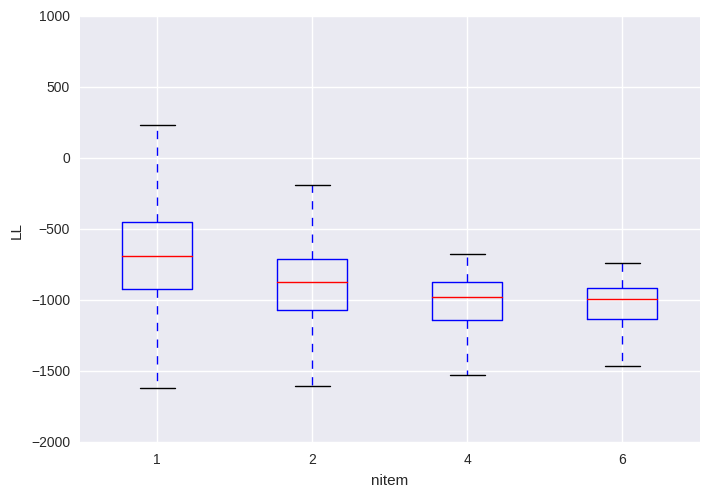

In [19]:
# Checking statistics of LL for different nitems
f, ax = plt.subplots()
ax.boxplot([result_ll_sum_avg[:, nitem] for nitem in xrange(4)], labels=T_space);
ax.set_ylim(-2000, 1000);
ax.set_ylabel('LL')
ax.set_xlabel('nitem')

In [20]:
LLsumAll = []
for nitem_i, nitem in enumerate(T_space):
    for LL in result_ll_sum_avg[:, nitem_i]:
        LLsumAll.append(dict(LL=LL, nitem=nitem))
LLsumAllPD = pd.DataFrame(LLsumAll)

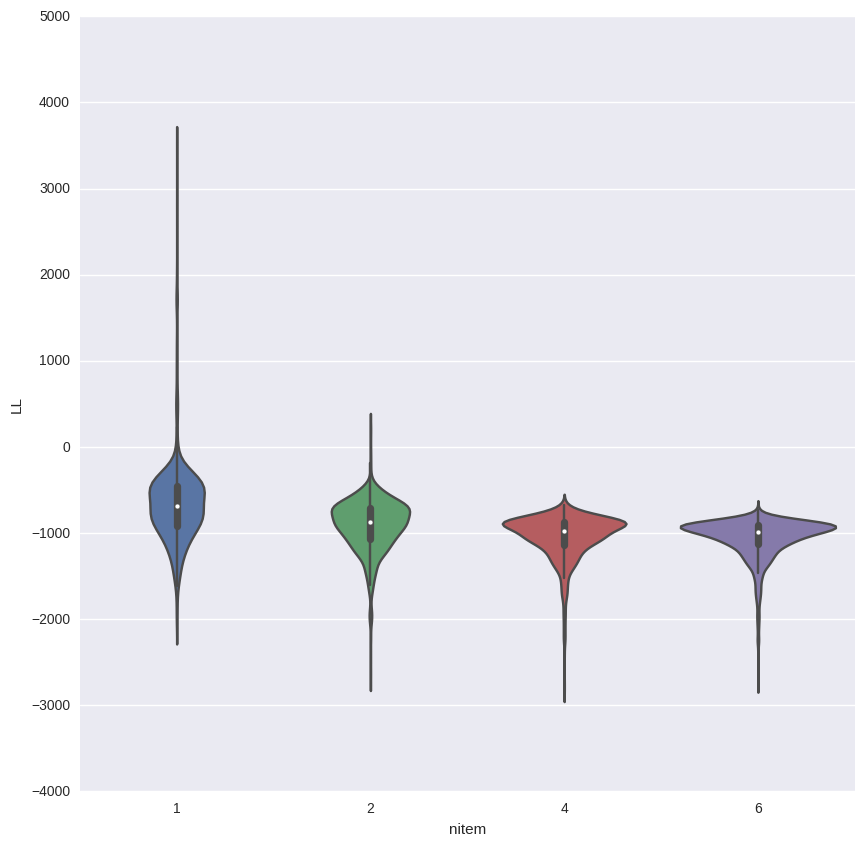

In [21]:
f, ax = plt.subplots(figsize=(10, 10))
sns.violinplot(data=LLsumAllPD, x='nitem', y='LL', ax=ax);

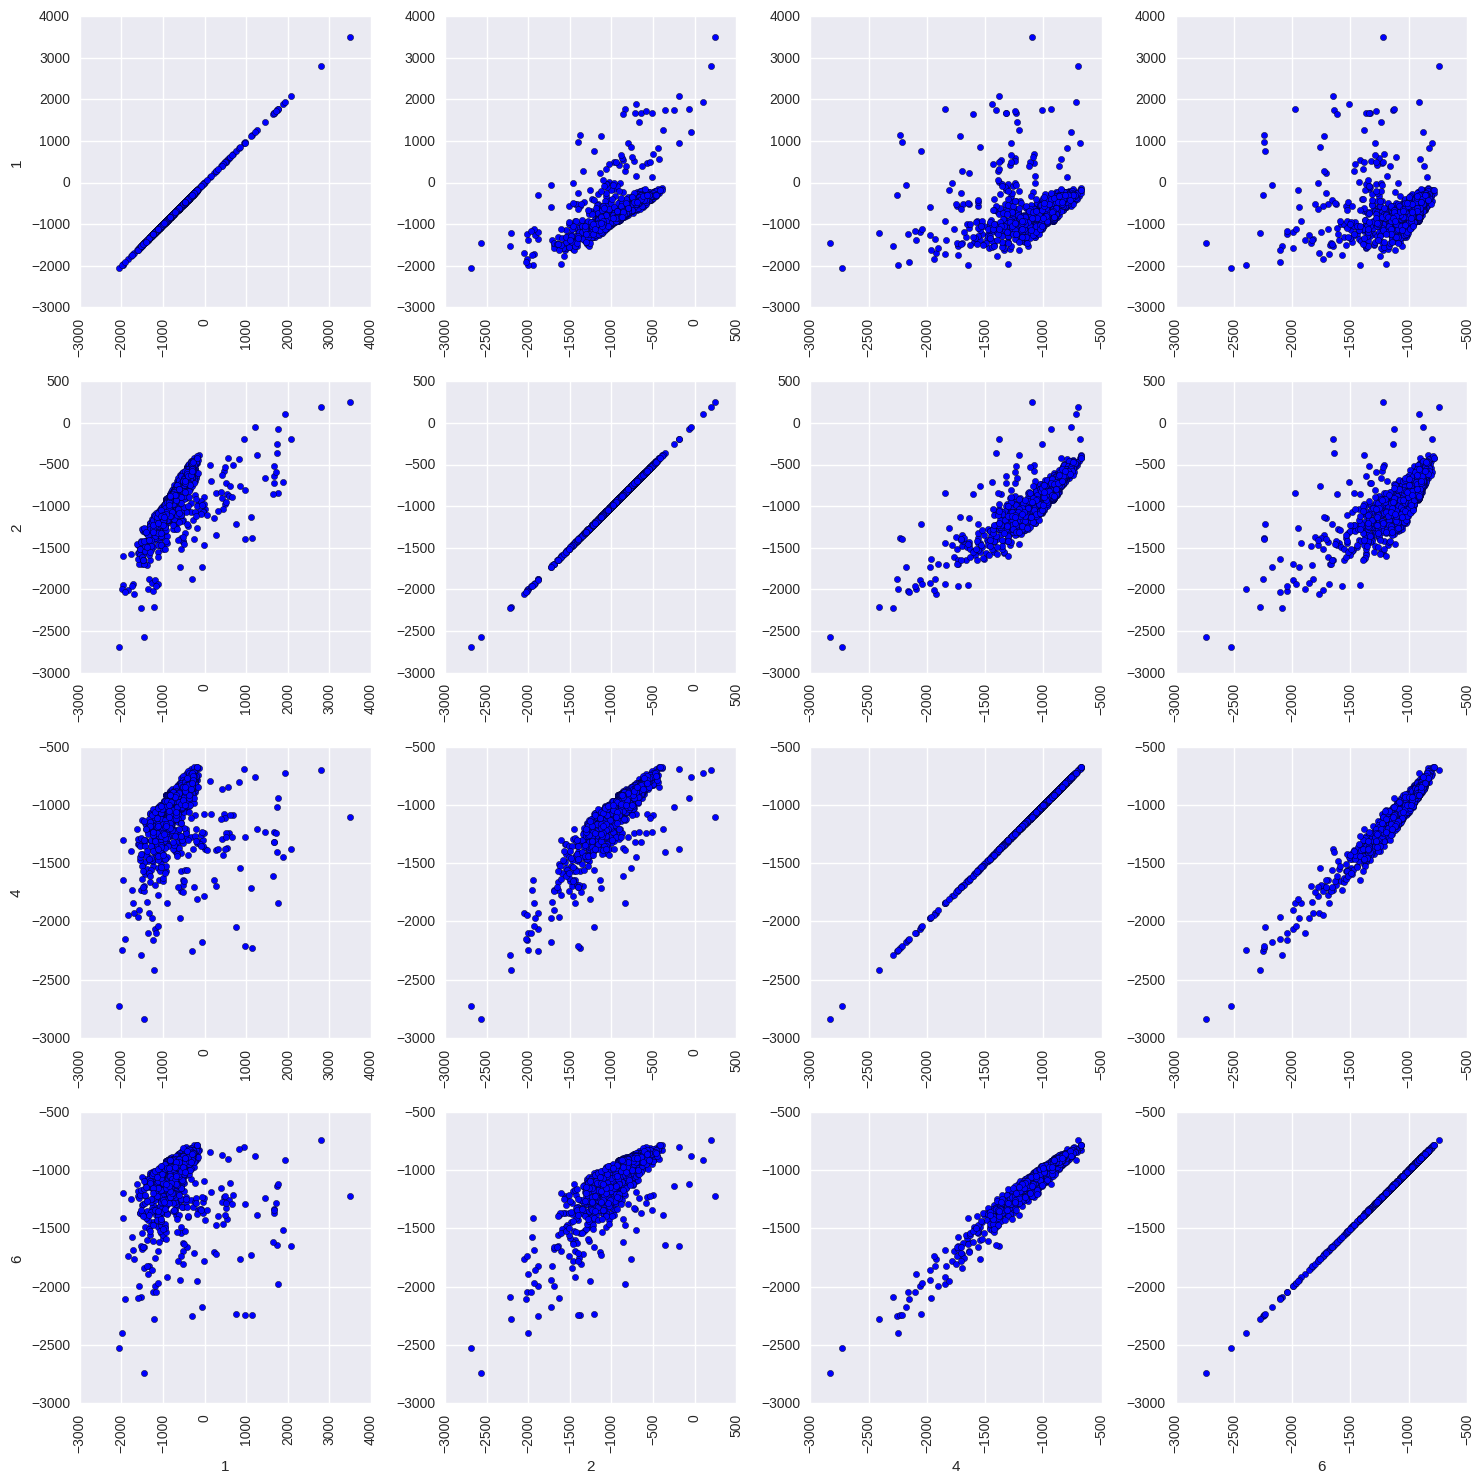

In [22]:
f, ax = plt.subplots(4, 4, figsize=(15, 15))
for y_nitem_i, y_nitem in enumerate(T_space):
    for x_nitem_i, x_nitem in enumerate(T_space):
        currAx = ax[y_nitem_i, x_nitem_i]
#         currAx.hist2d(result_ll_sum_avg[:, x_nitem_i], result_ll_sum_avg[:, y_nitem_i],
#                       bins=50, range=[[-2000, 1000], [-2000, 1000]], normed=True)
        currAx.scatter(result_ll_sum_avg[:, x_nitem_i], result_ll_sum_avg[:, y_nitem_i])
#         sns.kdeplot(result_ll_sum_avg[:, x_nitem_i], result_ll_sum_avg[:, y_nitem_i], ax=currAx)
        if x_nitem_i == 0:
            currAx.set_ylabel(y_nitem)
        if y_nitem_i == 3:
            currAx.set_xlabel(x_nitem)
#         currAx.set_xlim(result_ll_sum_avg[:, x_nitem_i].min(), result_ll_sum_avg[:, x_nitem_i].max())
    
        
        plt.sca(currAx)
        locs, labels = plt.xticks()
        plt.setp(labels, rotation=90)
        
plt.tight_layout()

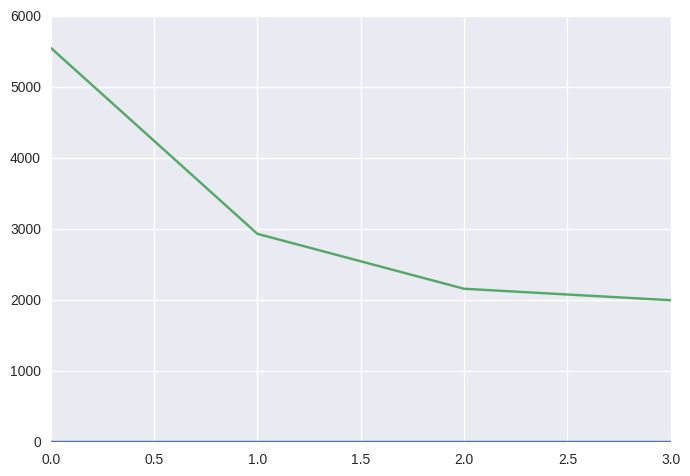

In [23]:
# Renormalized LL
plt.plot(np.arange(4), result_ll_sum_renormeach.min(axis=0), np.arange(4), result_ll_sum_renormeach.max(axis=0));

## -> Pandas now

In [51]:
df_all_fits = pd.DataFrame.from_items([('M', result_parameters_flat[:, 0]),
                                       ('ratio_conj', result_parameters_flat[:, 1]),
                                       ('sigmax', result_parameters_flat[:, 2]),
                                       ('lapse_rate', result_parameters_flat[:, 3]),
                                       ('dist_bic', result_dist_bic),
                                       ('dist_emfit_mse', result_dist_emfit_mse),
                                       ('dist_emfit_kl', result_dist_emfit_kl),
                                       ('dist_nll', result_dist_nll),
                                       ('dist_nll90', result_dist_nll90),
                                       ('dist_nllnormall_sum', result_dist_nllnormall_sum),
                                       ('dist_nllnormall_prod', result_dist_nllnormall_prod),
                                       ('dist_nllnormall_geom', result_dist_nllnormall_geom),
                                       ('dist_ll_median', result_dist_ll_median_avg),
                                      ])
df_all_fits = df_all_fits.assign(
    dist_emfit_mse_log = lambda x: np.log(x['dist_emfit_mse']),
    dist_emfit_kl_log = lambda x: np.log(x['dist_emfit_kl']),
    dist_nll_log = lambda x: np.log(x['dist_nll']),
    dist_nllnormall_prod_log = lambda x: np.log(x['dist_nllnormall_prod']),
)

In [79]:
# Filter rows where LL > cutoff value and remove lapse_rate > cutoff
# Good ones
LL_max_cutoff = 10000
LL_min_cutoff = -1500
lapserate_cutoff = 0.5
sigmax_min_cutoff = 0.05

# Bad
LL_max_cutoff = 10000
LL_min_cutoff = -15000
lapserate_cutoff = 0.3
sigmax_min_cutoff = 0.00005


df_best_fits = df_all_fits[df_all_fits.dist_nll < LL_max_cutoff]
df_best_fits = df_best_fits[df_best_fits.dist_nll > LL_min_cutoff]
df_best_fits = df_best_fits[df_best_fits.lapse_rate < lapserate_cutoff]
df_best_fits = df_best_fits[df_best_fits.sigmax > sigmax_min_cutoff]

In [80]:
## Correlations
df_best_fits.corr()

,M,ratio_conj,sigmax,lapse_rate,dist_bic,dist_emfit_mse,dist_emfit_kl,dist_nll,dist_nll90,dist_nllnormall_sum,dist_nllnormall_prod,dist_nllnormall_geom,dist_ll_median,dist_emfit_kl_log,dist_emfit_mse_log,dist_nll_log,dist_nllnormall_prod_log
M,1.000000,-0.023799,0.040877,0.003662,0.354300,-0.007473,0.089625,0.354300,0.341682,0.354300,0.424185,0.377219,0.408351,0.103647,0.464101,0.368297,0.409036
ratio_conj,-0.023799,1.000000,0.002143,-0.009703,-0.460470,0.017416,-0.329694,-0.460470,-0.494972,-0.460470,-0.532682,-0.480549,-0.420708,-0.431789,-0.595704,-0.476586,-0.516202
sigmax,0.040877,0.002143,1.000000,0.007668,-0.186112,-0.036984,0.514872,-0.186112,-0.156258,-0.186112,-0.168495,-0.244847,-0.507216,0.617376,-0.393252,-0.126485,-0.136819
lapse_rate,0.003662,-0.009703,0.007668,1.000000,-0.374961,-0.006054,0.115994,-0.374961,-0.282317,-0.374961,-0.315515,-0.384997,-0.161078,0.199128,0.037825,-0.332216,-0.293843
dist_bic,0.354300,-0.460470,-0.186112,-0.374961,1.000000,-0.052398,0.152551,1.000000,0.990892,1.000000,0.948836,0.985238,0.801355,0.160748,0.620769,0.967992,0.924375
dist_emfit_mse,-0.007473,0.017416,-0.036984,-0.006054,-0.052398,1.000000,0.169871,-0.052398,-0.050139,-0.052398,-0.038367,-0.006157,0.051439,0.048537,0.183111,-0.022914,-0.067655
dist_emfit_kl,0.089625,-0.329694,0.514872,0.115994,0.152551,0.169871,1.000000,0.152551,0.202616,0.152551,0.199343,0.124831,-0.065454,0.760524,0.219885,0.193166,0.207755
dist_nll,0.354300,-0.460470,-0.186112,-0.374961,1.000000,-0.052398,0.152551,1.000000,0.990892,1.000000,0.948836,0.985238,0.801355,0.160748,0.620769,0.967992,0.924375
dist_nll90,0.341682,-0.494972,-0.156258,-0.282317,0.990892,-0.050139,0.202616,0.990892,1.000000,0.990892,0.948484,0.970145,0.799583,0.225895,0.639650,0.969009,0.927796
dist_nllnormall_sum,0.354300,-0.460470,-0.186112,-0.374961,1.000000,-0.052398,0.152551,1.000000,0.990892,1.000000,0.948836,0.985238,0.801355,0.160748,0.620769,0.967992,0.924375


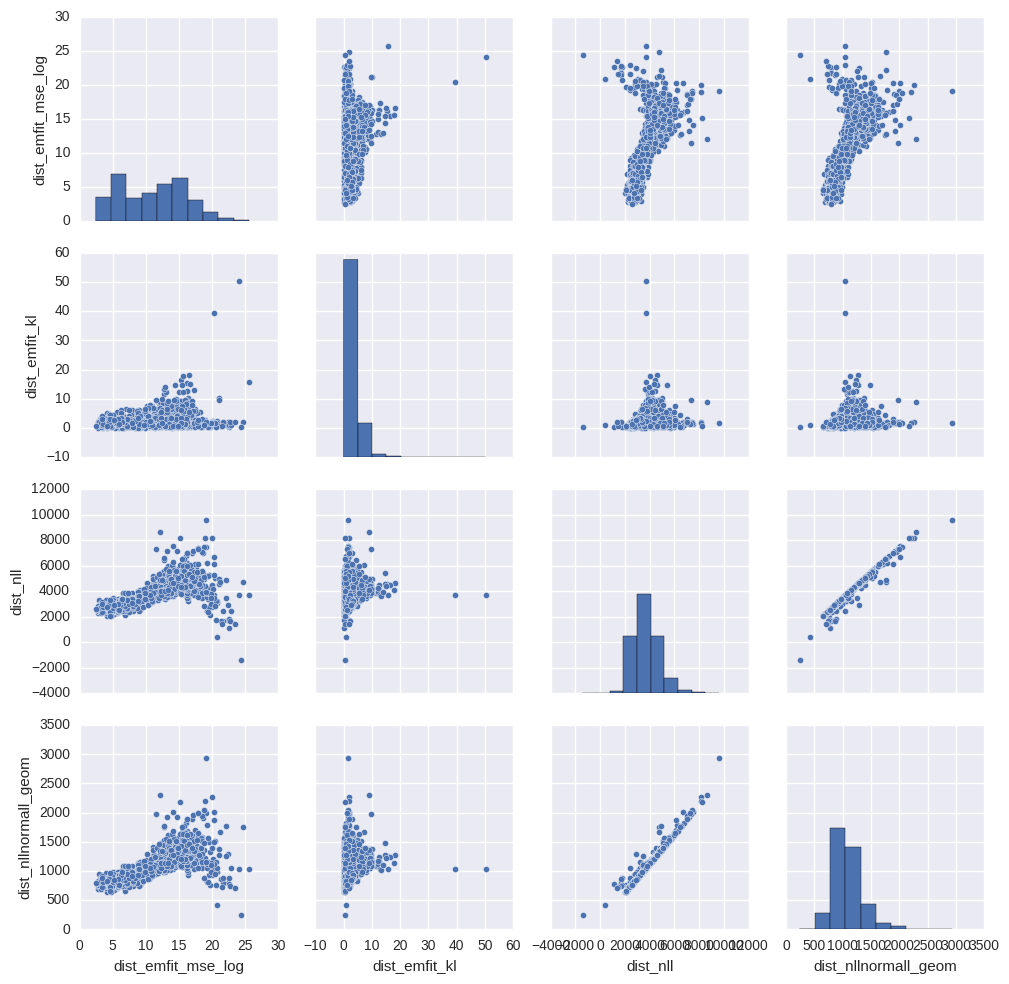

In [81]:
# Cross-correlation plots
sns.pairplot(df_best_fits,
             x_vars=['dist_emfit_mse_log', 'dist_emfit_kl', 'dist_nll', 'dist_nllnormall_geom'],
             y_vars=['dist_emfit_mse_log', 'dist_emfit_kl', 'dist_nll', 'dist_nllnormall_geom']
            )

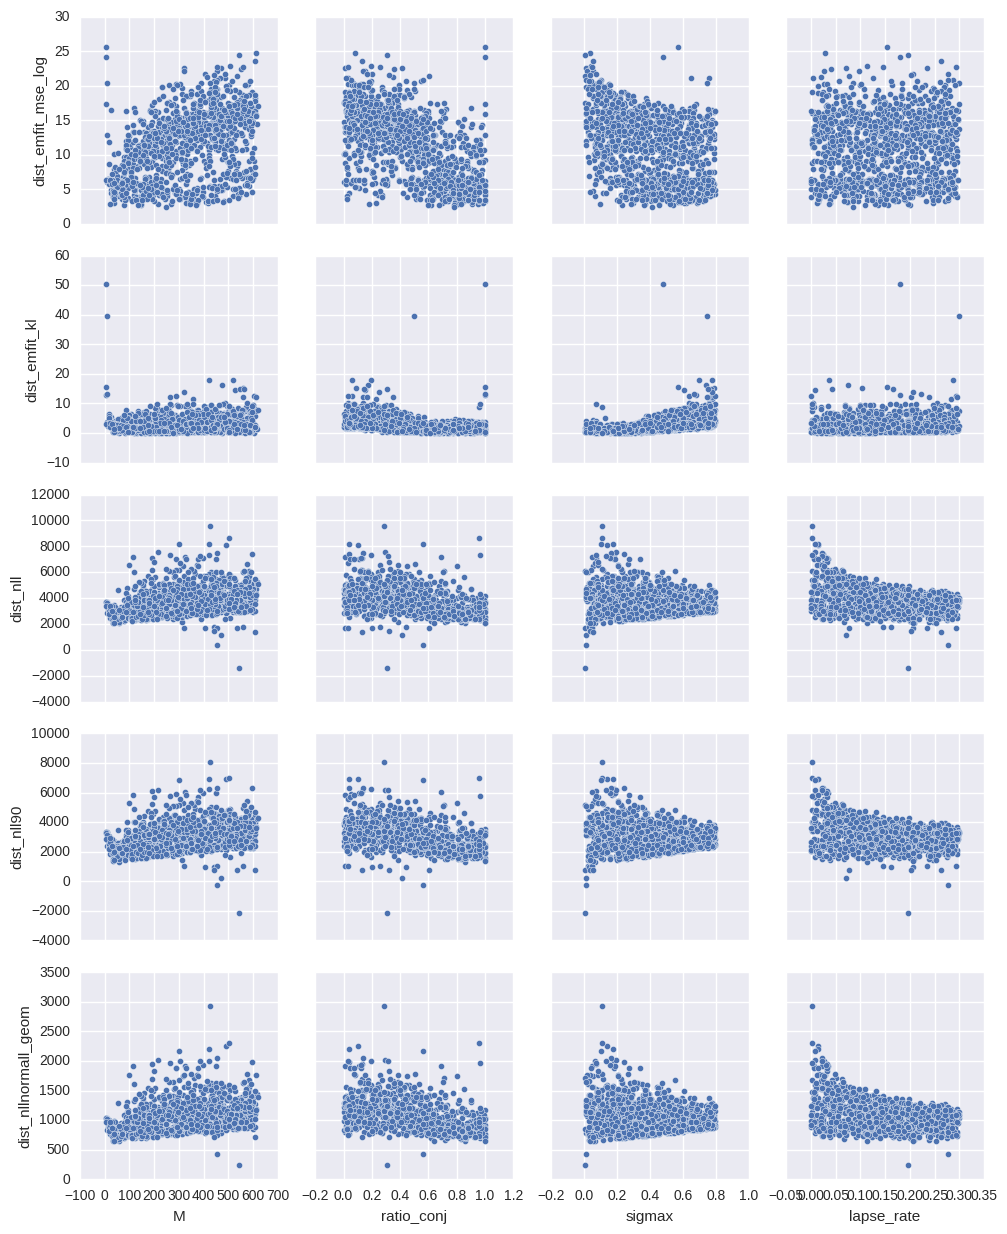

In [82]:
# Check parameters effects
sns.pairplot(df_best_fits,
             x_vars=['M', 'ratio_conj', 'sigmax', 'lapse_rate'],
             y_vars=['dist_emfit_mse_log', 'dist_emfit_kl', 'dist_nll', 'dist_nll90', 'dist_nllnormall_geom']
            )

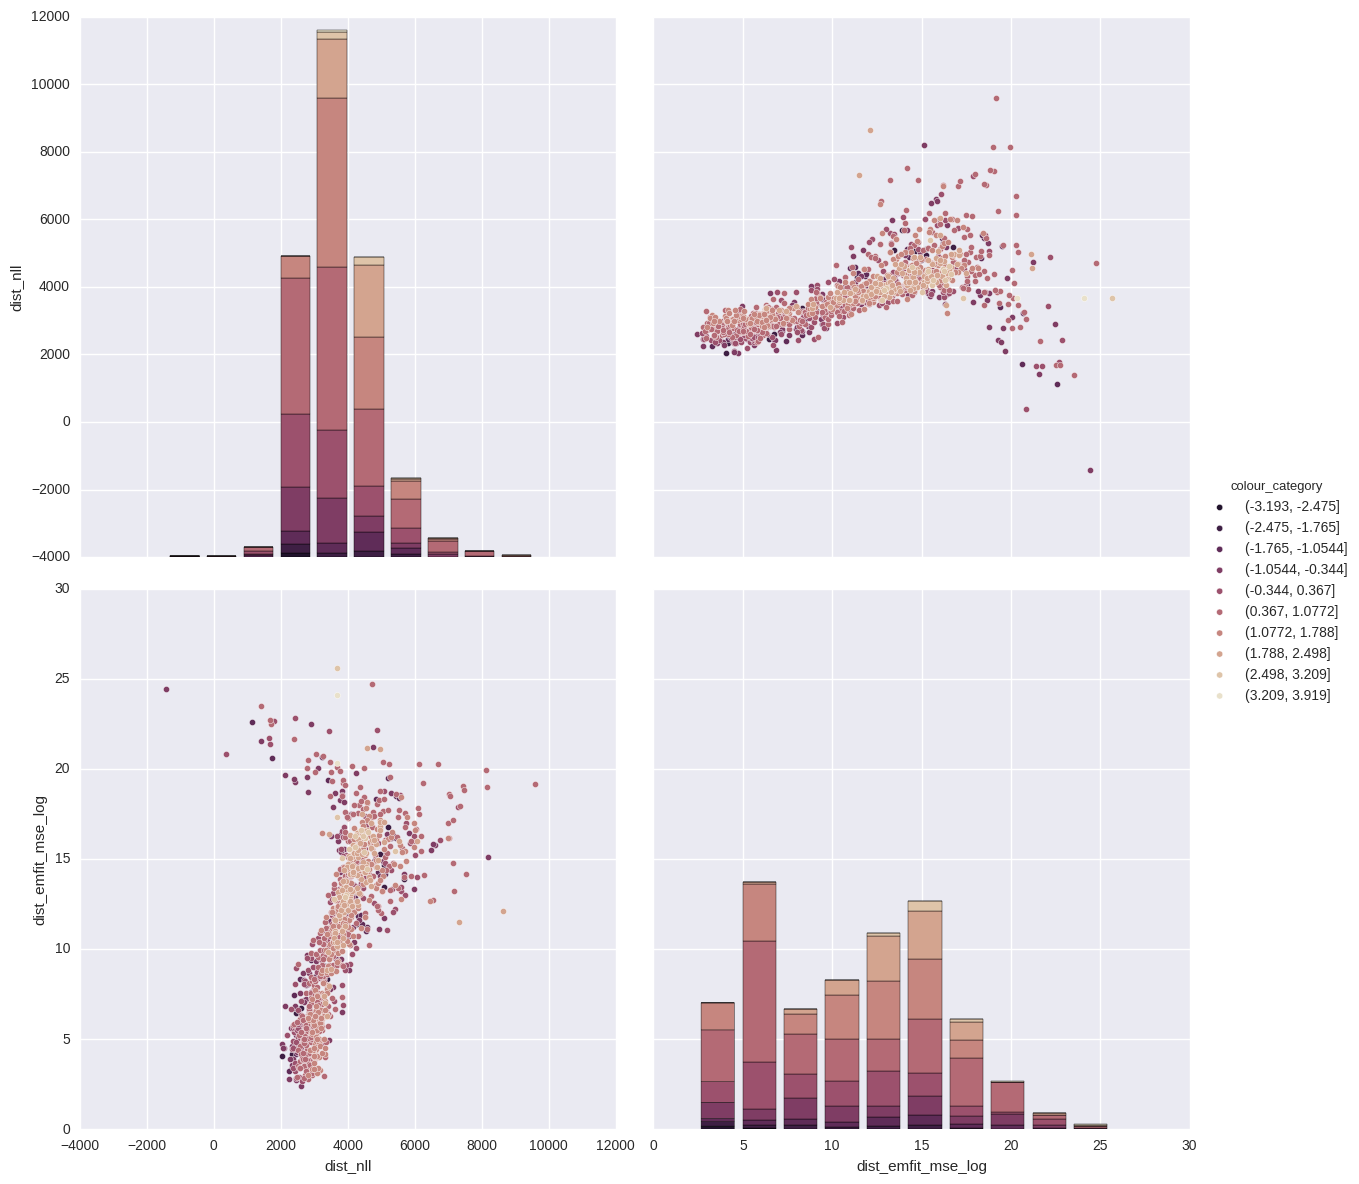

In [104]:
# Color code for Colour KL fit this time 
mycubehelix = sns.cubehelix_palette(dark=0.15, n_colors=10, start=0, rot=0.5, gamma=1.2, hue=0.9, light=0.9, reverse=True)
gp = sns.pairplot(df_best_fits.assign(colour_category=pd.cut(np.log(df_best_fits['dist_emfit_kl']), bins=10)),
             hue='colour_category',
             palette=mycubehelix,
             vars=['dist_nll', 'dist_emfit_mse_log',],
             size = 6
            )


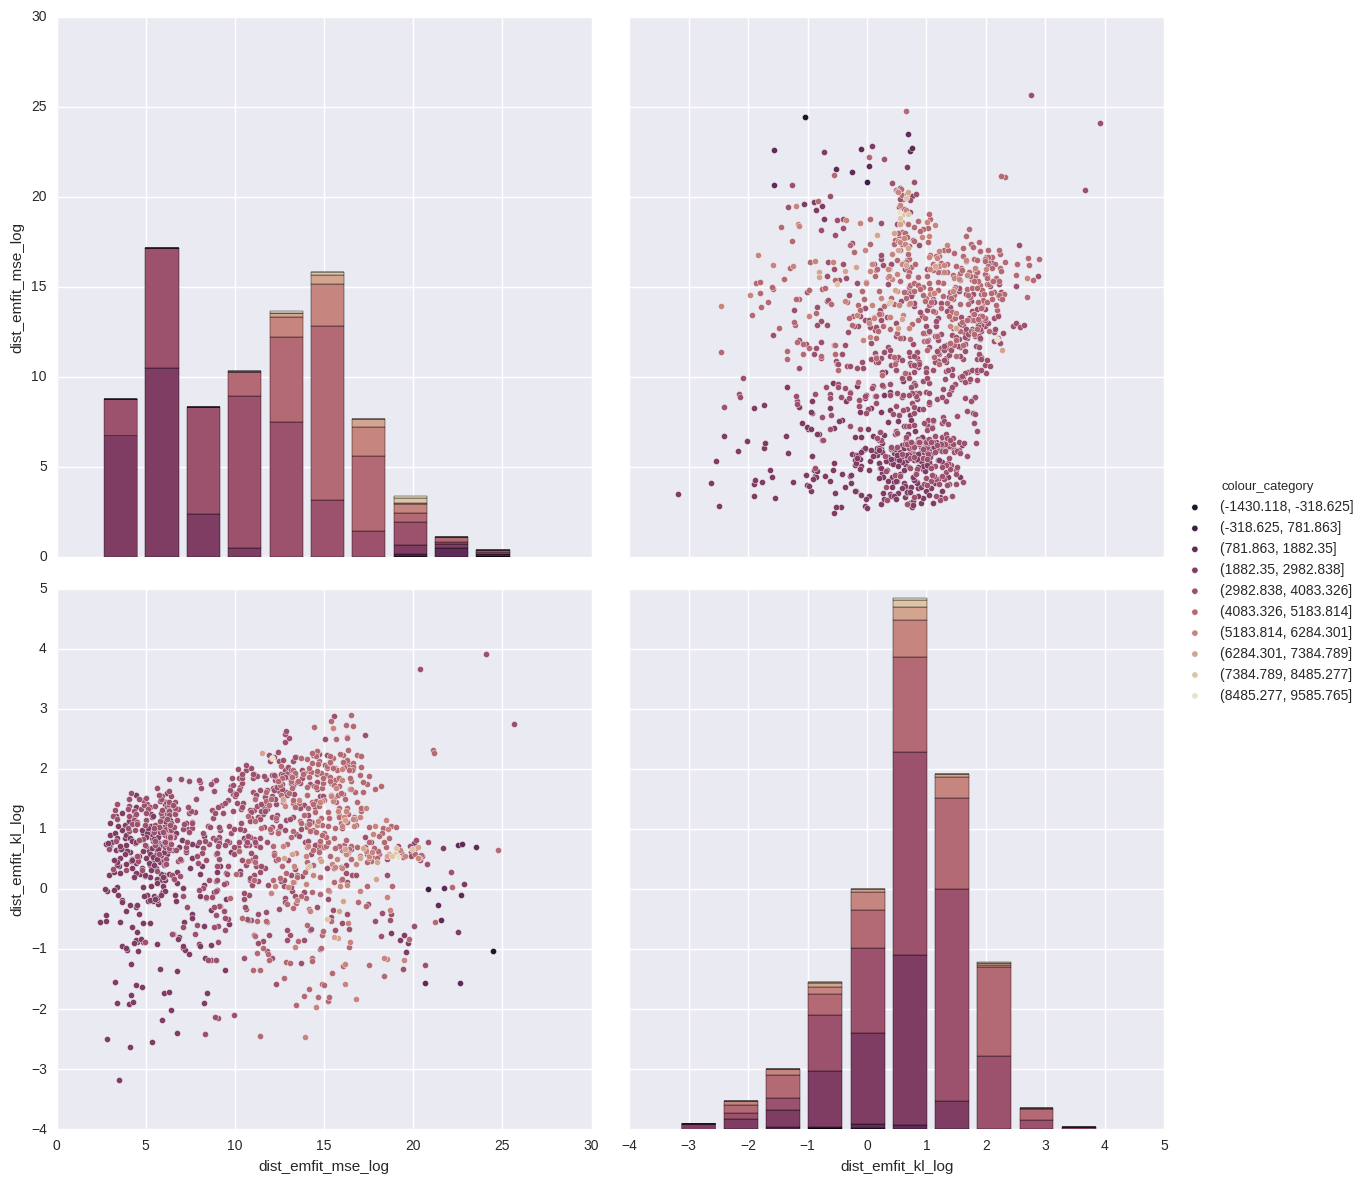

In [84]:
# Color code for Colour KL fit this time 
mycubehelix = sns.cubehelix_palette(dark=0.15, n_colors=10, start=0, rot=0.5, gamma=1.2, hue=0.9, light=0.9, reverse=True)
sns.pairplot(df_best_fits.assign(colour_category=pd.cut((df_best_fits['dist_nll']), bins=10)),
             hue='colour_category',
             palette=mycubehelix,
             vars=['dist_emfit_mse_log', 'dist_emfit_kl_log'],
             size = 6
            )

## Plotly Scatter3d

In [27]:
# result_to_color = np.array(df_best_fits.dist_nll90)

# col_min = np.min(result_to_color)
# col_max = np.max(result_to_color)

# text = ['> %s' % (x) for x in result_to_color]

# trace1 = Scatter3d(
#         x= df_best_fits.M,
#         y= df_best_fits.ratio_conj,
#         z= df_best_fits.sigmax,
#         text= text,
#         mode= 'markers',
#         marker= Marker(
#             color = result_to_color,
#             size = 7,
#             colorscale='Bluered',
#             cmin=col_min,
#             cmax=col_max,
#             cauto=False
#         )
#     )
# data = Data([trace1])
# layout = Layout(
#     title='Landscape for NLL90',
#     scene=Scene(
#         xaxis=XAxis(
#             title=df_best_fits.columns.values[0],
#         ),
#         yaxis=YAxis(
#             title=df_best_fits.columns.values[1],
#         ),
#         zaxis=ZAxis(
#             title=df_best_fits.columns.values[2],
#         )
#     )
# )
# fig = Figure(data=data, layout=layout)
# scatter3d_url = py.plot(fig)

In [28]:
# dropdown_space = parameter_names_sorted
# dropdown_default = 'lapse_rate'
# metric_color_space = ['dist_emfit_mse', 'dist_emfit_kl', 'dist_nll', 'dist_nll90', 'dist_bic', 'dist_nllnormall_geom']
# metric_color_default = 'dist_nll90'

# g = GraphWidget(scatter3d_url)

# class shifter:
#     def __init__(self):
#         self.slider_index = 0
#         self.marker_size = 8
#         self.filter_results = slice(None, None)
#         self.metric_color = metric_color_default
#         self.dropdown_value = dropdown_default
        
#         self.change_color_source(metric_color_default)
#         self.change_dropdown_value(dropdown_default)
    
#     def change_dropdown_value(self, new_value):
#         self.dropdown_value = new_value
        
#         # Update the axes
#         self.axes_parameters = dropdown_space[:]
#         self.axes_parameters.remove(self.dropdown_value)
        
#         # Update the grid of the dropdown parameter
#         self.dropparam_gridified, self.dropparam_gridspace, self.dropparam_midspace = utils.gridify(df_best_fits[self.dropdown_value], bins=10)
        
        
    
#     def change_color_source(self, new_value):
#         self.metric_color = new_value
#         self.result_to_color = np.array(df_best_fits[self.metric_color])
#         self.result_to_color[self.result_to_color > 2*np.median(self.result_to_color)] = np.median(self.result_to_color)
#         self.col_min = np.min(self.result_to_color)
#         self.col_max = np.max(self.result_to_color)
    
#     def on_color_source_change(self, name, old_value, new_value):
#         self.change_color_source(new_value)
#         self.replot()
    
#     def on_dropdown_change(self, name, old_value, new_value):
#         self.change_dropdown_value(new_value)
#         p_slider.description='%s [all]' % self.dropdown_value
#         self.replot()
    
#     def on_slider_change(self, name, old_value, new_value):
#         self.slider_index = new_value
        
#         if self.slider_index > -1:
#             self.filter_results = self.dropparam_gridified[self.slider_index]
#             self.marker_size = 6
#             p_slider.description='%s [%f]' % (self.dropdown_value, self.dropparam_gridspace[self.slider_index])
#         else:
#             self.filter_results = slice(None, None)
#             self.marker_size = 6
#             p_slider.description='%s [all]' % self.dropdown_value
        
#         self.text = ['%s > %s' % (x[0], x[1]) for x in 
#                      zip(df_best_fits[self.dropdown_value][self.filter_results], self.result_to_color[self.filter_results])]
        
#         self.replot()
        
#     def replot(self):
#         self.text = ['%s > %s' % (x[0], x[1]) for x in 
#                      zip(df_best_fits[self.dropdown_value][self.filter_results], self.result_to_color[self.filter_results])]
        
#         new_trace = Scatter3d(
#             x= df_best_fits[self.axes_parameters[0]][self.filter_results],
#             y= df_best_fits[self.axes_parameters[1]][self.filter_results],
#             z= df_best_fits[self.axes_parameters[2]][self.filter_results],
#             text= self.text,
#             mode= 'markers',
#             marker= Marker(
#                 color = self.result_to_color[self.filter_results],
#                 size = self.marker_size,
#                 colorscale='Bluered',
#                 cmin=self.col_min,
#                 cmax=self.col_max,
#                 cauto=False
#             )
#         )
#         g.restyle({'x': [[]], 'y': [[]], 'z': [[]], 'marker':None, })
#         g.relayout({'title' : "Landscape for %s" % self.metric_color,
#                     'scene.xaxis.title': self.axes_parameters[0],
#                     'scene.yaxis.title': self.axes_parameters[1],
#                     'scene.zaxis.title': self.axes_parameters[2],
#                     })
#         g.add_traces(new_trace)

# p_state = shifter()
# p_metric_drop = widgets.Dropdown(description='Metric for color', options=metric_color_space, value=metric_color_default)
# p_variable_drop = widgets.Dropdown(description='Variable to slide', options=dropdown_space, value=dropdown_default)
# p_slider = widgets.IntSlider(min=-1, max=p_state.dropparam_midspace.size-1, value=-1)
# p_slider.description='%s [all]' % p_state.dropdown_value

# p_slider.on_trait_change(p_state.on_slider_change, 'value')
# p_variable_drop.on_trait_change(p_state.on_dropdown_change, 'value')
# p_metric_drop.on_trait_change(p_state.on_color_source_change, 'value')

# p_state.replot()

In [29]:
# display(p_metric_drop)
# display(p_variable_drop)
# display(p_slider)
# display(g)

## Look at best parameters


In [85]:
max_best_params = 10

print_str_best_params_df(df_best_fits, 'dist_emfit_mse', max_best_params)
print
1297
print_str_best_params_df(df_best_fits, 'dist_emfit_kl', max_best_params)
print

print_str_best_params_df(df_best_fits, 'dist_nll', max_best_params)
print

print_str_best_params_df(df_best_fits, 'dist_nll90', max_best_params)
print

print_str_best_params_df(df_best_fits, 'dist_bic', max_best_params)
print

print_str_best_params_df(df_best_fits, 'dist_nllnormall_geom', max_best_params)
print

print_str_best_params_df(df_best_fits, 'dist_ll_median', max_best_params)

Best for dist_emfit_mse
[  i ] M ratio_conj sigmax lapse_rate >> dist_emfit_mse dist_emfit_kl dist_nll dist_nll90 dist_bic dist_nllnormall_geom
[1277] 250.0000 0.7840 0.4136 0.0844 >> 11.3789 0.5753 2610.1633 1820.6141 5319.7604 787.8687
[1134] 135.0000 0.6000 0.4544 0.1086 >> 14.9553 1.0016 2628.8218 1918.6340 5357.0774 790.5823
[ 671] 148.0000 0.6757 0.3664 0.1350 >> 15.7151 0.5916 2464.2545 1762.4920 5027.9426 750.0794
[ 364] 79.0000 0.6203 0.2311 0.1997 >> 16.1153 0.6476 2244.6542 1608.3571 4588.7421 695.6453
[1078] 371.0000 0.7790 0.5405 0.1555 >> 16.1361 2.1321 2798.0557 2098.2079 5695.5451 832.6461
[ 997] 149.0000 0.8121 0.2842 0.0377 >> 16.8296 0.0828 2473.8800 1571.5800 5047.1938 756.3798
[ 439] 216.0000 0.9074 0.3717 0.1965 >> 17.3301 0.9656 2449.4080 1788.9282 4998.2498 747.3684
[1172] 347.0000 0.8329 0.5213 0.1481 >> 17.6106 2.1620 2701.6823 1998.7124 5502.7984 809.5715
[1013] 22.0000 0.1818 0.1001 0.1298 >> 18.4369 2.0475 2493.8558 1865.0560 5087.1454 763.7883
[ 375] 270.0

In [64]:
result_dist_ll_median_avg

array([ 2.0305363 ,  2.09028576,  2.14811906, ...,  1.1650641 ,
        1.9480292 ,  1.51129943])

In [65]:
ll_all = result_ll_nn_flat.reshape(result_ll_nn_flat.shape[0], -1)
ll_all_mean = np.mean(ll_all, axis=-1)
ll_all_median = np.median(ll_all, axis=-1)

In [66]:
np.argmax(ll_all_median)

155

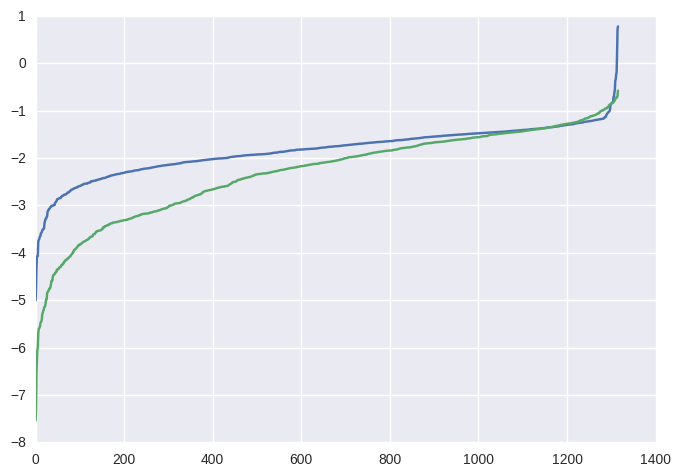

In [67]:
plt.plot(np.sort(ll_all_mean))
plt.plot(np.sort(-result_dist_ll_median_avg))

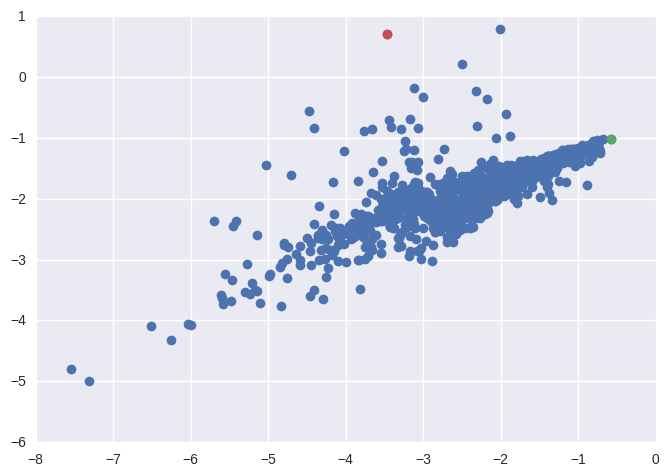

In [86]:
plt.plot(-result_dist_ll_median_avg, ll_all_mean, 'o')
# some points
i = 155
plt.plot(-result_dist_ll_median_avg[i], ll_all_mean[i], 'o')

i = 1025
plt.plot(-result_dist_ll_median_avg[i], ll_all_mean[i], 'o')

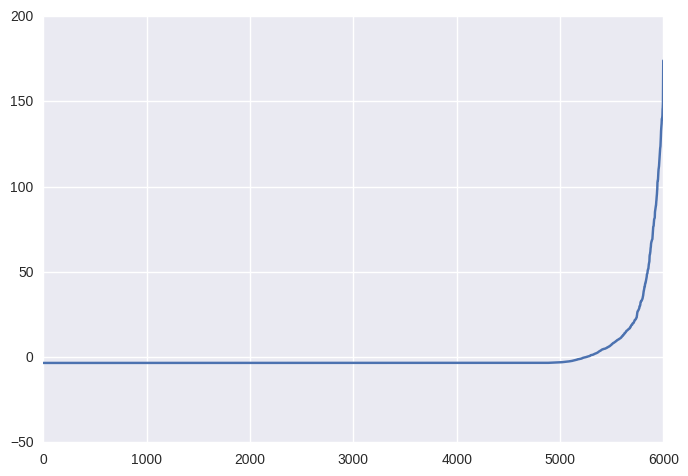

In [91]:
dd = ll_all[1025]
plt.plot(np.sort(dd))

WARNING, THIS IS FITTED ON FULL DATA, NOT 500 FIRST SAMPLES AS OUR MODEL


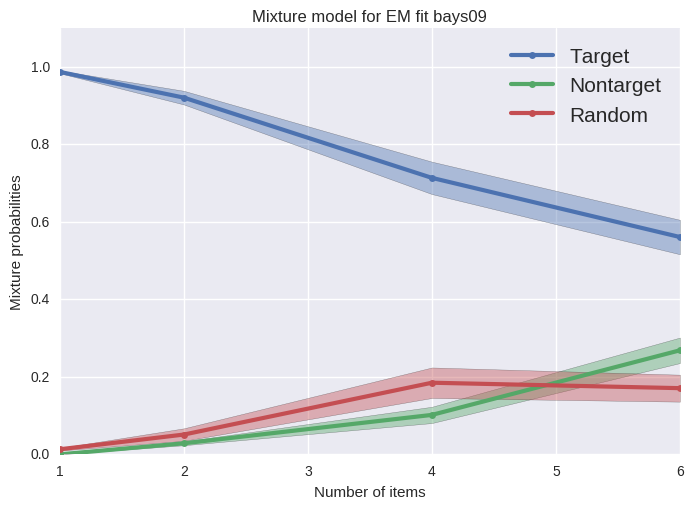

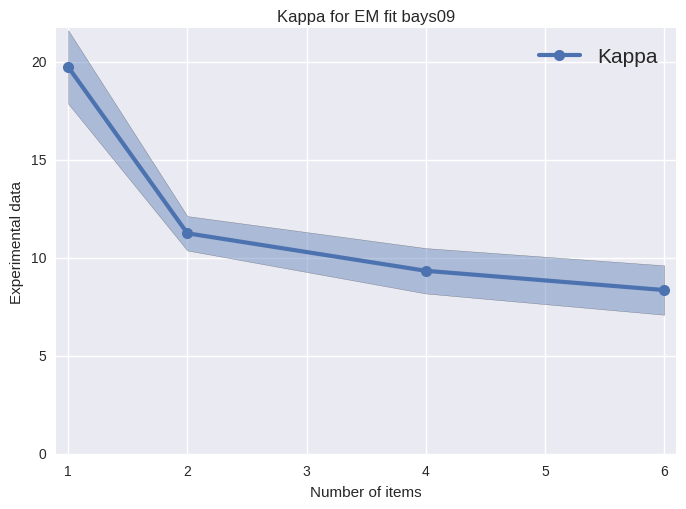

In [87]:
# Ground truth
print 'WARNING, THIS IS FITTED ON FULL DATA, NOT 500 FIRST SAMPLES AS OUR MODEL'
plots_experimental_data.plots_bays2009(data_groundtruth)

# Collapsed Kappa for comparison
# print 'Collapsed Kappa, slightly better LL, again fitted on full data!'
# plots_experimental_data.plots_collapsed_em_mixtures(data_groundtruth)

# Plot best
def plot_modelfits(T_space, curr_result_emfits_t, labelplot='', dataio=None):
    curr_result_avg = np.mean(curr_result_emfits_t, axis=-1)
    curr_result_std = np.std(curr_result_emfits_t, axis=-1)
    
    f, ax = plt.subplots()    
    ax = plots_experimental_data.plot_kappa_mean_error(T_space, curr_result_avg[..., 0], curr_result_std[..., 0], title=labelplot, ax=ax, label='Kappa', xlabel='Number of items')

    if dataio is not None:
        dataio.save_current_figure('bestfit_%s_kappa_{label}_{unique_id}.pdf' % labelplot)

    f, ax = plt.subplots()
    ax = plots_experimental_data.plot_emmixture_mean_error(T_space, curr_result_avg[..., 1], curr_result_std[..., 1], title=labelplot, label='Target', xlabel='Number of items', ax=ax)
    ax = plots_experimental_data.plot_emmixture_mean_error(T_space, curr_result_avg[..., 2], curr_result_std[..., 2], title=labelplot, label='Nontarget', xlabel='Number of items', ax=ax)
    ax = plots_experimental_data.plot_emmixture_mean_error(T_space, curr_result_avg[..., 3], curr_result_std[..., 3], title=labelplot, label='Random', xlabel='Number of items', ax=ax)
    
    if dataio is not None:
        dataio.save_current_figure('bestfit_%s_mixttarget_{label}_{unique_id}.pdf' % labelplot)

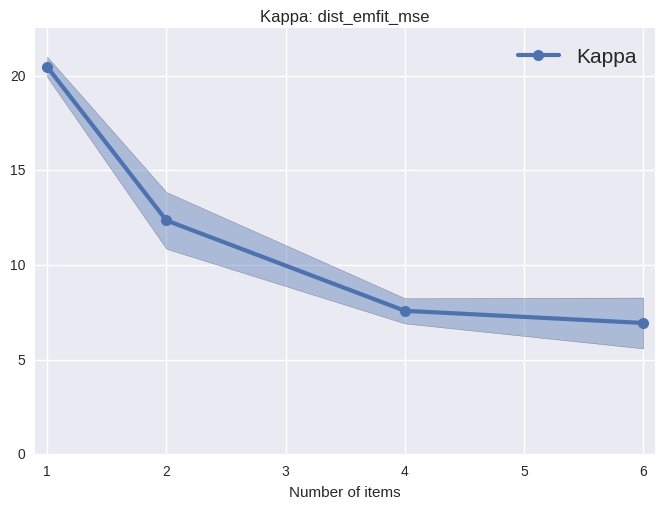

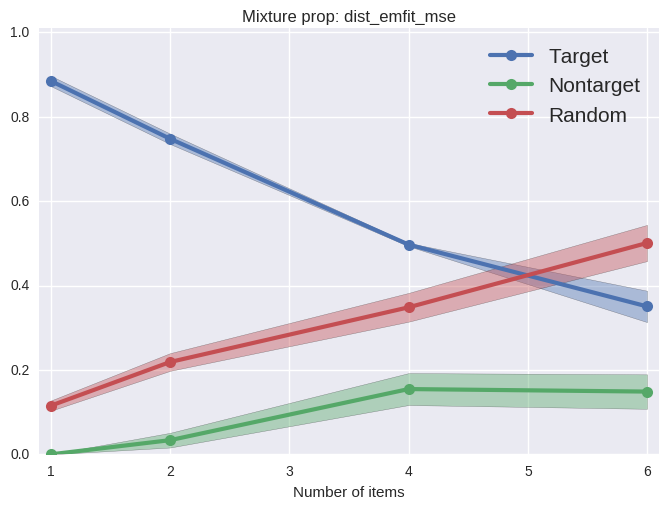

In [88]:
# Best fit for EM MSE
@interact(best_index=(0, 9, 1), metric=['dist_emfit_mse', 'dist_emfit_kl', 'dist_nll', 'dist_nll90'])
def plot_model_fit(metric='dist_emfit_mse', best_index=0):
    df_sorted = sort_df_best_params(df_best_fits, metric, max_best_params)
    plot_modelfits(T_space, result_em_fits_flat[df_sorted.index[best_index]], metric)

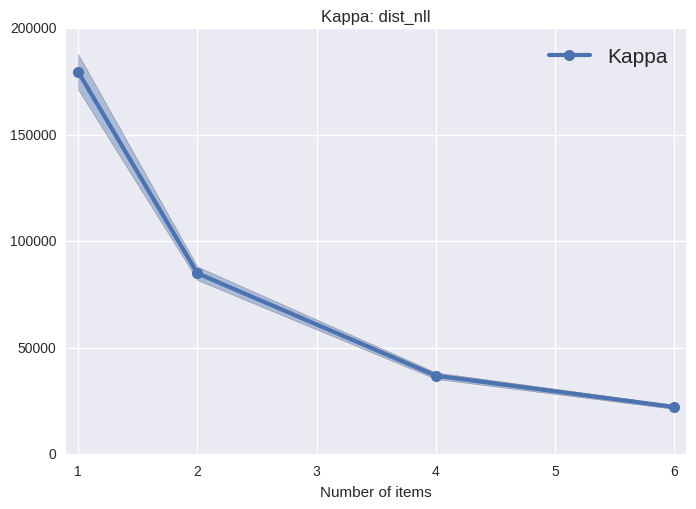

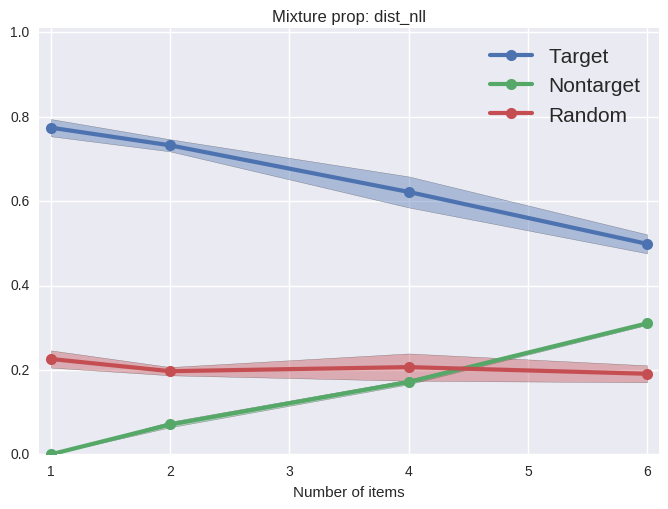

In [90]:
# Best fit for NLL
@interact(best_index=(0, 9, 1), metric=['dist_emfit_mse', 'dist_emfit_kl', 'dist_nll', 'dist_nll90', 'dist_nllnormall_geom'])
def plot_model_fit(metric='dist_nll', best_index=0):
    df_sorted = sort_df_best_params(df_best_fits, metric, max_best_params)
    plot_modelfits(T_space, result_em_fits_flat[df_sorted.index[best_index]], metric)

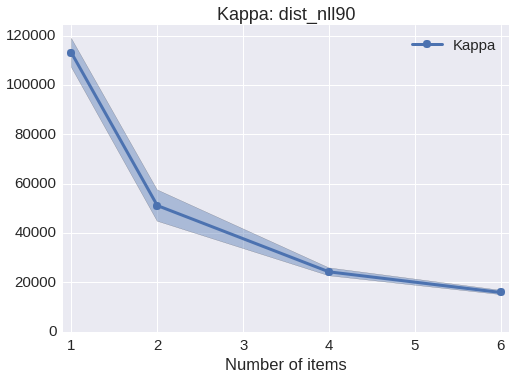

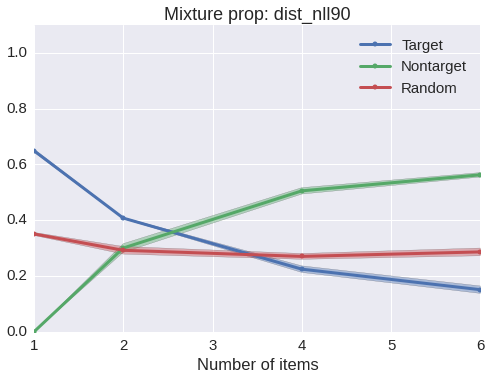

In [168]:
# Best fit for NLL90
@interact(best_index=(0, 9, 1), metric=['dist_emfit_mse', 'dist_emfit_kl', 'dist_nll', 'dist_nll90', 'dist_nllnormall_geom'])
def plot_model_fit(metric='dist_nll90', best_index=0):
    df_sorted = sort_df_best_params(df_best_fits, metric, max_best_params)
    plot_modelfits(T_space, result_em_fits_flat[df_sorted.index[best_index]], metric)

In [93]:
# # Best fit for LL Geometric mean
# @interact(best_index=(0, 9, 1), metric=['dist_emfit_mse', 'dist_emfit_kl', 'dist_nll', 'dist_nll90', 'dist_nllnormall_geom'])
# def plot_model_fit(metric='dist_nllnormall_geom', best_index=0):
#     df_sorted = sort_df_best_params(df_best_fits, metric, max_best_params)
#     plot_modelfits(T_space, result_em_fits_flat[df_sorted.index[best_index]], metric)

In [98]:
# # Compute EM Mixture fits on subset of data used by our model, to compare LL and BIC properly
# dataset = data_groundtruth
# responses_subset = np.empty((T_space.size, 500))
# targets_subset = np.empty((T_space.size, 500))
# nontargets_subset = np.empty((T_space.size, 500, T_space[-1] - 1))

# for T_i, T in enumerate(T_space):
#     responses_subset[T_i] = dataset['data_to_fit'][T]['response'][:500]
#     targets_subset[T_i] = dataset['data_to_fit'][T]['item_features'][:500, 0, 0]
#     nontargets_subset[T_i, :, :(T-1)] = dataset['data_to_fit'][T]['item_features'][:500, 1:T, 0]

# params_fit = em_circularmixture_parametrickappa.fit(T_space,
#         responses_subset, targets_subset, nontargets_subset, debug=False)

# f, ax = plt.subplots()

# ax.plot(T_space, params_fit['mixt_target'])
# ax.plot(T_space, params_fit['mixt_nontargets'])
# ax.plot(T_space, params_fit['mixt_random'])

# ax.legend(prop={'size':15})

# ax.set_title('Mixture model for Collapsed EM fit %s' % dataset['name'])
# ax.set_xlim([1.0, T_space.max()])
# ax.set_ylim([0.0, 1.1])
# ax.set_xticks(range(1, T_space.max()+1))
# ax.set_xticklabels(range(1, T_space.max()+1))

# f.canvas.draw()

# # Kappa
# f, ax = plt.subplots()

# ax.plot(T_space, params_fit['kappa'])

# ax.legend(prop={'size':15})
# ax.set_title('Kappa for Collapsed EM fit %s' % dataset['name'])
# ax.set_xlim([0.9, T_space.max()+0.1])
# ax.set_ylim([0.0, np.max(dataset['collapsed_em_fits']['mean']['kappa'])*1.1])
# ax.set_xticks(range(1, T_space.max()+1))
# ax.set_xticklabels(range(1, T_space.max()+1))
# ax.get_figure().canvas.draw()

In [96]:
# BIC now
print 'EM Model NLL: ', -params_fit['train_LL']
print 'EM Model BIC: ', params_fit['bic']
print

# Our Model BIC:
print 'Model BIC is around 4000'
print 'Our model BIC, for good fit, best_index 4:'
print '[ 907] 81.0000 1.0000 0.2028 0.0382 >> 29.4631 0.1496 2332.5732 1449.1216 4764.5802'

EM Model NLL:  1558.72187876
EM Model BIC:  3201.00646895

Model BIC is around 4000
Our model BIC, for good fit, best_index 4:
[ 907] 81.0000 1.0000 0.2028 0.0382 >> 29.4631 0.1496 2332.5732 1449.1216 4764.5802


# Observations

So this is a better situation than with sigma_output.

There is some overlap between the best parameters, and apart from some specific sub-parameters regions that have high LL but low emfits (it's a valid/wrong strategy :P Super extra precise on a few points, random on others), most things are compatible.

More precisely:
* LL90 is well correlated with emfit_kl, at 0.8. Good points for LL90 usually have good emfit_kl scores.
* LL90 is kinda correlated with emfit_mse, 0.6. But as always, getting this properly is quite hard. I'm starting CMA/ES runs now and we will see, but this may be problematic. 
* Looking at the 3D views, we see that best parameters for emfit_mse and emfit_kl do not really overlap well. And squinting a bit, it does nearly look like LL90 is going for the best of both, although a bit more prefering emfit_kl. So that's great in my opinion, at least it's not doing something completely stupid!

Choosing among the top-10 LL90 values get some nice and acceptable fits.

Using LL instead shows that the lapse rate is always higher, so some bad trials are really driving the whole loglikelihood down dramatically.

### Update Dec 20th:

While doing CMA/ES, I found that using the sum of the LL between number of items ends up badly misrepresenting the nitem=1 case.
Basically, because the ranges of the LL are not matched between the nitems-cases, you get better summed scores by just fitting the 1 item case!

To counteract that, we need to normalise the LL per item. But:
- This is nearly impossible in a principled way, as we have no idea of knowing what the likelihood of the worst model is...
- We can go around that by using a multiplicative cost. Meaning we go to a geometric mean, which will equally try to fit all nitems-cases. But for that, we need to make sure all the LL are positive or negative.
- To do this, we can either remove the max value or add the min value seen so far. This corresponds to either:
    1. Compare each model to the best likelihood possible accross conditions, a bit weird.
    2. Compare each model to the worst likelihood across all conditions. It could be seen as doing a likelihood ratio vs the worst possible model. Not sure if that worst possible model could be the random model? Or perhaps the one that associate 0 probability to everything?
- Doing this normalisation by the min value seems to work quite well actually! Now (after some shifting business to get a distance cost, where small is good) the default optimal is actually quite acceptable for both EM MSE and EM KL metrics, and visually looks pretty possible.

Only issue is how to do this in CMA/ES:
- Maybe do it hardcore: online. Models through time will tend to decrease in overall fitness in jumps (resp. increase in loss), but hopefully CMA/ES will cope with it and not backtrack? Could try...
- Just remove a large min value, the worst possible ever, just to make sure everything is positive. But then the LL themselves mean nothing, and it could fail miserably.

=> Should try both


## Showing best params with FitExperiment

In [43]:
#df_bestparams_nll = df_best_fits.sort_values(by='dist_ll_median', ascending=True).head(1).median()
df_bestparams_nll = df_best_fits.loc[705]

df_bestparams_nll


M                           8.100000e+01
ratio_conj                  1.000000e+00
sigmax                      2.028299e-01
lapse_rate                  3.818331e-02
dist_bic                    4.764580e+03
dist_emfit_mse              2.946309e+01
dist_emfit_kl               1.496355e-01
dist_nll                    2.332573e+03
dist_nll90                  1.449122e+03
dist_nllnormall_sum        -9.005624e+03
dist_nllnormall_prod        5.136292e+13
dist_nllnormall_geom        7.195826e+02
dist_ll_median              7.298513e-01
dist_emfit_mse_log          3.383138e+00
dist_nll_log                7.754727e+00
dist_nllnormall_prod_log    3.156994e+01
Name: 705, dtype: float64

In [145]:
# Check best parameters
experiment_parameters = dict(action_to_do='launcher_do_fitexperiment_allmetrics',
                             inference_method='none',
                             experiment_id='bays09',
                             selection_method='last',
                             renormalize_sigma=None,
                             sigmay=0.00001,
                             num_samples=100,
                             code_type='mixed',
                             slice_width=0.07,
                             burn_samples=50,
                             ratio_conj=0.7,
                             num_repetitions=2,
                             stimuli_generation_recall='random',
                             autoset_parameters=None,
                             filter_datapoints_size=100, 
                             filter_datapoints_selection='random'
                             )

experiment_parameters.update(df_bestparams_nll)
for key in ['M']:
    experiment_parameters[key] = int(experiment_parameters[key])

with io.capture_output(display=False, stdout=True) as captured:
    experiment_launcher = ExperimentLauncher(run=True, arguments_dict=experiment_parameters)
    fit_exp = experiment_launcher.all_vars['fit_exp']
    results = experiment_launcher.all_vars['all_outputs_data']
    plots_fit_exp = PlotsFitExperimentAllTPaperTheo(fit_exp)
        

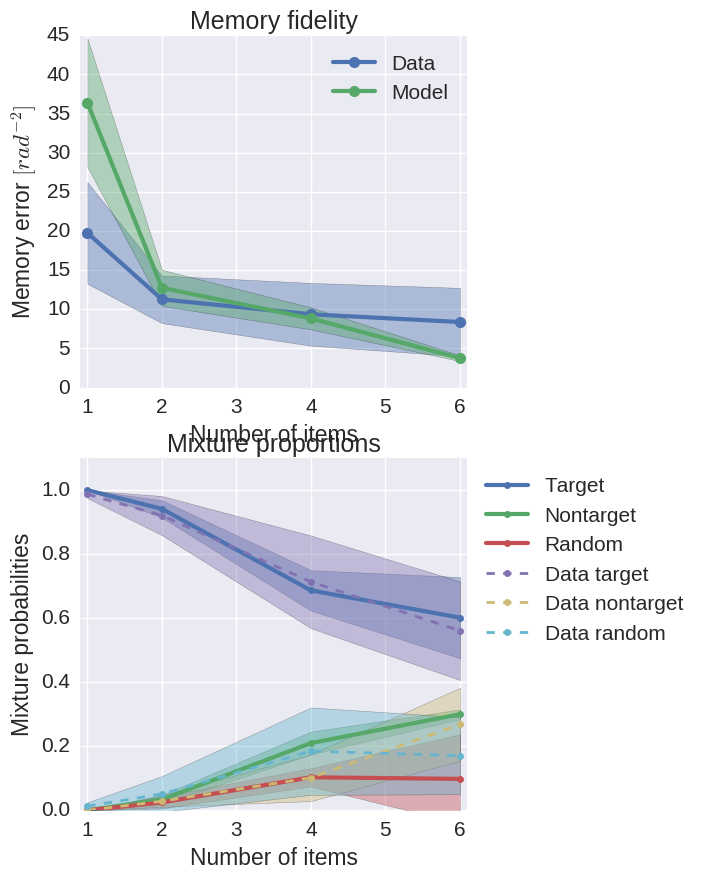

In [46]:
with io.capture_output(display=False, stdout=True) as captured:
    axesFig6Fig13 = plots_fit_exp.plots_memmixtcurves_fig6fig13(num_repetitions=3, use_cache=True)
    axesFig6Fig13[0].figure.set_size_inches((5, 10))

## Writing plots for thesis

In [114]:
dataio.create_formatted_filename('llfailure_scatterplot_{label}_{unique_id}.pdf')

'/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/outputs/llfailure_scatterplot_global_plots_fitexperiment_bays09_Mratiosigmaxlapserate_b3546546-19f9-4fac-8e4e-5de04bc4032d.pdf'

In [113]:
# Scatter plot
gp.fig.savefig(dataio.create_formatted_filename('llfailure_scatterplot_{label}_{unique_id}.pdf'))

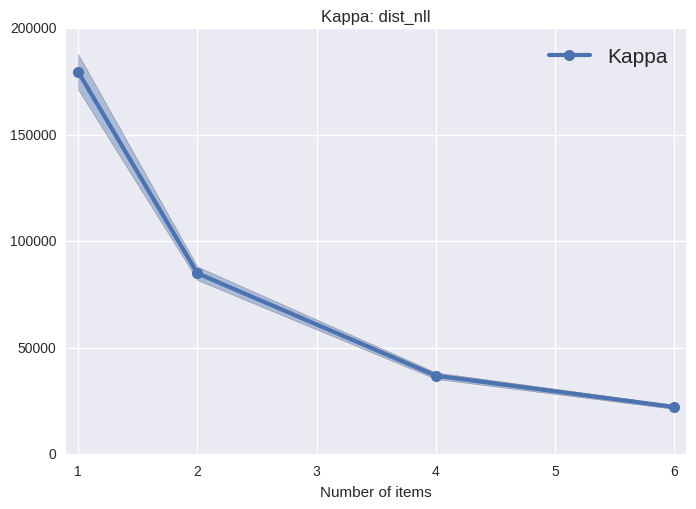

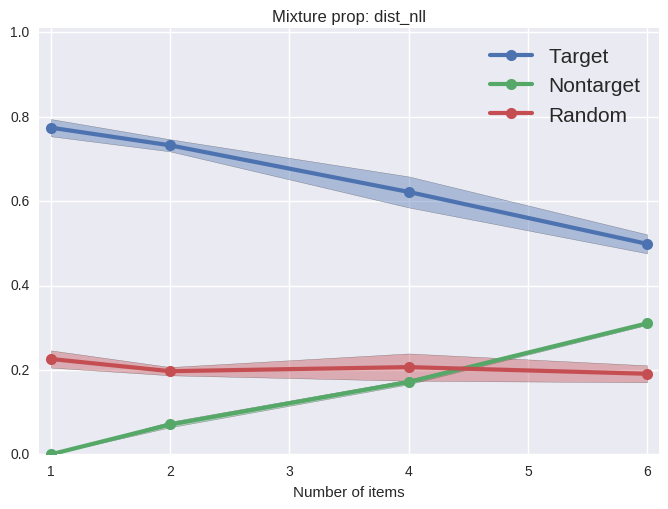

In [106]:
metric='dist_nll'
best_index=0

df_sorted = sort_df_best_params(df_best_fits, metric, max_best_params)
plot_modelfits(T_space, result_em_fits_flat[df_sorted.index[best_index]], metric, dataio=dataio)

In [115]:
dataio.make_link_output_to_dropbox(dropbox_current_experiment_folder='fitexperiment_allt_new_10_2015')

Doing dropbox symlink:  /nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/outputs/ /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Experiments/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015_outputs
